# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)
6. [Correlations](#correlations)


# Data Description
The original dataset was in a Matlab format. The data was converted to CSV format for easier handling. The self-developed Matlab-Export--Scripts are in the folder [Matlab-Export-Scripts](./MatlabExport).

- The Data are recorded with 240Hz
- The NASA TLX Scores are recorded after each task

The Description of the original data is in the file [Data Description](./readme.txt)

# New Data Format

The new data structure is as follows:
- Participants.csv: Contains the participant information with some demographic data and a unique participant ID.
- Participant_X
    - Test1: 5 Images, no time constraint, no secondary task.
        - Participant_X_Annotations_1.csv: Contains the annotations for the test.
        - Participant_X_Blinks_1.csv: Contains the blinks data for the test.
        - Participant_X_Gaze_1.csv: Contains the gaze data for the test.
        - Participant_X_Pupil_1.csv: Contains the pupil data for the test.
    - Test2: 5 iamges, with time constraint, no secondary task.
    - Test3: 5 images, with time constraint, with secondary task.
    - Test4: 5 images, no time constraint, with secondary task.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Load Data

In [82]:
# Variables
data_path = '../Data/'

# Load data
participant_list = pd.read_csv(data_path + 'participants.csv')
print(participant_list.head())

   ID  VisualAcuity_logMAR_ Gender  Age  Education
0   1                 -0.04      F   28         18
1   2                 -0.10      F   28         18
2   3                 -0.08      F   38         16
3   4                 -0.07      F   29         18
4   5                 -0.15      M   30         18


In [90]:



# initiate an array to store the data
# 47 rows = 74 participants,
# 1. column = Participant ID
# 2.-5. columns = 4 tests

# each test: 
# 1. mental rating
# 2. physical rating
# 3. temporal rating
# 4. performance rating
# 5. effort rating
# 6. frustration rating
# 7. mean rating
# 8. values blinks
# 9. values gaze
# 10. values pupil

# 4 columns = 4 tests
participant_tests = np.zeros((participant_list.shape[0], 5), dtype=object)


# iterate over all participants and tests
for participant_number in range(1, participant_list.shape[0]+1):
    for test_number in range(1, 5):
        path_to_participant = data_path + 'Participant_' + str(participant_number) 
        path_to_test = path_to_participant + '/Test' + str(test_number) + '/'
        path_to_annotations = path_to_test + 'Participant_' + str(participant_number) + '_Annotations_' + str(test_number) + '.csv'
        path_to_blinks = path_to_test + 'Participant_' + str(participant_number) + '_Blinks_' + str(test_number) + '.csv'
        path_to_gaze = path_to_test + 'Participant_' + str(participant_number) + '_Gaze_' + str(test_number) + '.csv'
        path_to_pupil = path_to_test + 'Participant_' + str(participant_number) + '_Pupil_' + str(test_number) + '.csv'
        
        # change the column names of the NASA TLX values in all participants and all tests, so there is no number in the column name
        annotations = pd.read_csv(path_to_annotations)
        annotations.columns = ['mental', 'physical', 'temporal', 'performance', 'effort', 'frustration', 'mean']

        participant_tests[participant_number-1][test_number-1] = \
            [participant_number,
             annotations, 
             [pd.read_csv(path_to_blinks)], 
             [pd.read_csv(path_to_gaze)], 
             [pd.read_csv(path_to_pupil)]]


print(participant_tests.shape)
print(participant_tests[:1])


(47, 5)
[[list([1,    mental  physical  temporal  performance  effort  frustration  mean
  0      10         5        15           25      25           10    15, [   id  start_timestamp  duration  end_timestamp  start_frame_index  index  \
  0   1      5437.625617  0.236131    5437.861748                 37     40
  1   2      5444.161561  0.180073    5444.341634                231    233

     end_frame_index  confidence  \
  0               44    0.703872
  1              236    0.553669

                                       filter_response  \
  0  0.5068225043614704 0.5512669488059149 0.595711...
  1  0.5048782729116744 0.5493227173561188 0.592878...

                                             base_data
  0  5437.625617 5437.629564 5437.633621 5437.63786...
  1  5444.161561 5444.165642 5444.169793 5444.17554...  ], [      gaze_timestamp  world_index  confidence  norm_pos_x  norm_pos_y  \
  0        5410.551715            0    0.999499    0.446264    0.846886
  1        5410.5558

In [46]:
partcipant_1_test_1 = participant_tests[0][0]
print("Participant ID: " + str(partcipant_1_test_1[0]))
print("Participant NASA TLX Values: " + str(partcipant_1_test_1[1]))
print("Blink Werte: " + str(partcipant_1_test_1[2]))
print("Gaze Werte: " + str(partcipant_1_test_1[3]))
print("Pupil Werte: " + str(partcipant_1_test_1[4]))


Participant ID: 1
Participant NASA TLX Values:    mental  physical  temporal  performance  effort  frustration  mean
0      10         5        15           25      25           10    15
Blink Werte: [   id  start_timestamp  duration  end_timestamp  start_frame_index  index  \
0   1      5437.625617  0.236131    5437.861748                 37     40   
1   2      5444.161561  0.180073    5444.341634                231    233   

   end_frame_index  confidence  \
0               44    0.703872   
1              236    0.553669   

                                     filter_response  \
0  0.5068225043614704 0.5512669488059149 0.595711...   
1  0.5048782729116744 0.5493227173561188 0.592878...   

                                           base_data  
0  5437.625617 5437.629564 5437.633621 5437.63786...  
1  5444.161561 5444.165642 5444.169793 5444.17554...  ]
Gaze Werte: [      gaze_timestamp  world_index  confidence  norm_pos_x  norm_pos_y  \
0        5410.551715            0    0.9994

# Pupil Data
Only use diameter with a high confidence level. <br>
A dialted pupil can be a sign of cognitive load -> <br>
Romano Bergstrom, Jennifer (2014). Eye Tracking in User Experience Design || Physiological Response Measurements., 81–108. <br> 
doi:10.1016/b978-0-12-408138-3.00004-2  

In [91]:

# filter the pupil values, so only rows with a confidence level of 0.8 are included
# if there is a row with the same timestamp, use the one with the higher confidence level
# save only the columns timestamp, confidence, and diameter and method


# do it in a loop
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_pupil = participant_test[4][0]
    participant_test_pupil_filtered = participant_test_pupil[participant_test_pupil['confidence'] > 0.8]
    participant_test_pupil_filtered = participant_test_pupil_filtered.sort_values('confidence', ascending=False).drop_duplicates('pupil_timestamp').sort_index()
    participant_test_pupil_filtered = participant_test_pupil_filtered[['pupil_timestamp', 'confidence', 'diameter', 'method']]
    participant_tests[0][i][4][0] = participant_test_pupil_filtered



# normalize the time, so for each test the time starts at 0
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_pupil = participant_test[4][0]
    participant_test_pupil['pupil_timestamp'] = participant_test_pupil['pupil_timestamp'] - participant_test_pupil['pupil_timestamp'].iloc[0]
    participant_tests[0][i][4][0] = participant_test_pupil

print(participant_tests[0][0][4][0].head())

   pupil_timestamp  confidence   diameter  method
0         0.000000         1.0  40.757561  2d c++
3         0.004075         1.0  38.723305  2d c++
4         0.007878         1.0  40.842903  2d c++
6         0.011694         1.0  39.237560  2d c++
9         0.017295         1.0  40.950336  2d c++


In [113]:
#calculate the overall time based on the pupil data for each test. the unit is seconds
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_pupil = participant_test[4][0]
    print("Time Test " + str(i+1) + ": " + str(participant_test_pupil['pupil_timestamp'].iloc[-1]/1000) + " seconds")

Time Test 1: 0.03364395000000059 seconds
Time Test 2: 0.02848432200000025 seconds
Time Test 3: 0.07142382300000008 seconds
Time Test 4: 0.038163442000000034 seconds


In [92]:
# print each NASA TLX value for each test
for i in range(4):
    participant_test = participant_tests[0][i]
    print(str(participant_test[1]))

   mental  physical  temporal  performance  effort  frustration  mean
0      10         5        15           25      25           10    15
   mental  physical  temporal  performance  effort  frustration  mean
0      50        30        25           50      15           25  32.5
   mental  physical  temporal  performance  effort  frustration  mean
0     100        10        75           80      90           20  62.5
   mental  physical  temporal  performance  effort  frustration  mean
0      60        15        45           50      20           25  35.8


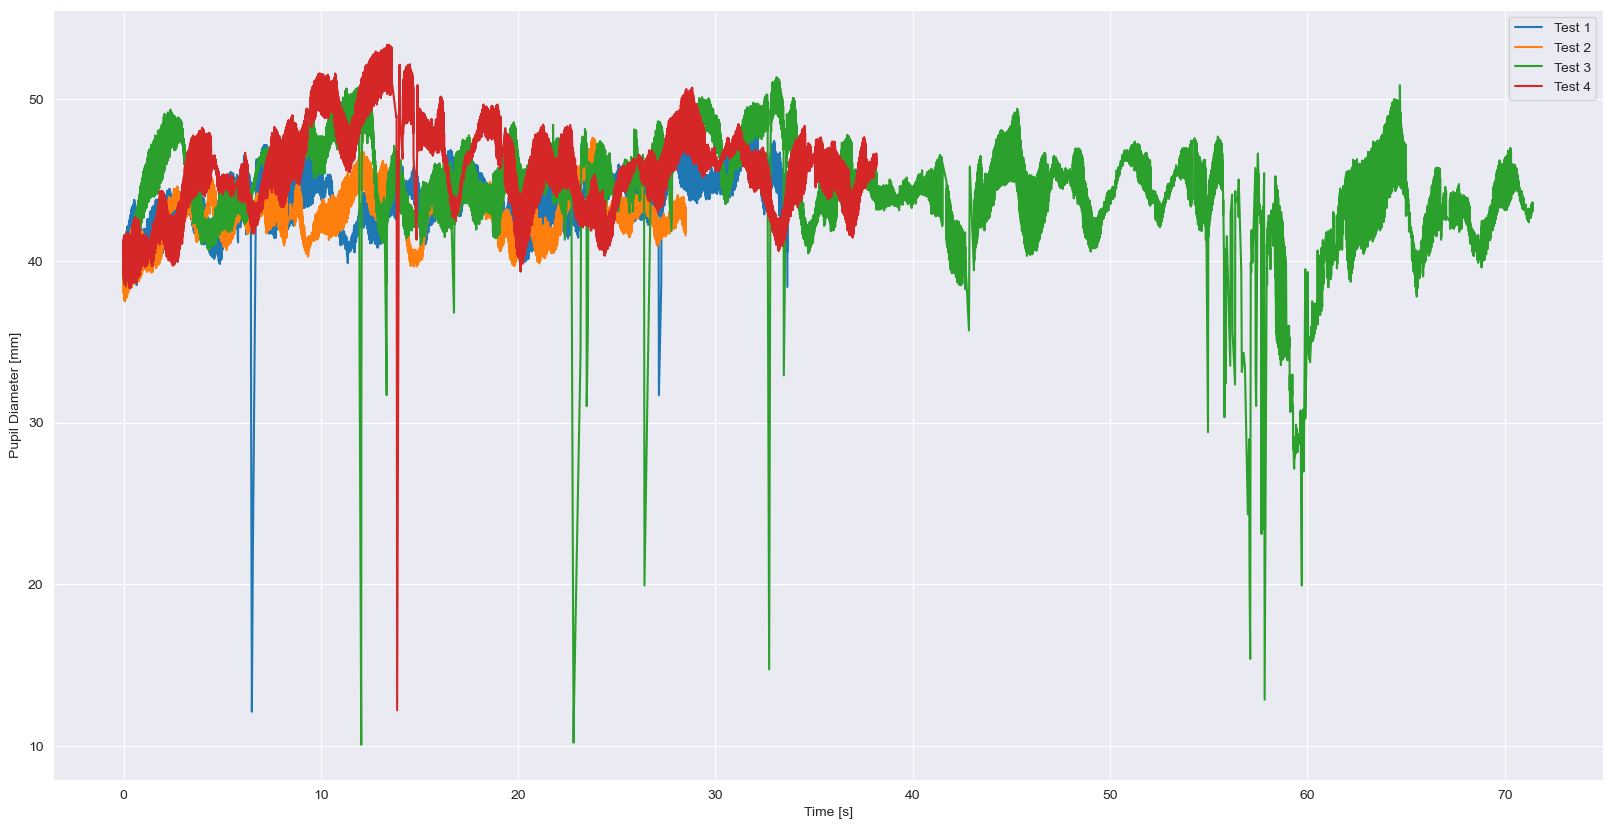

In [114]:
# plot the pupil diameter over time for all tests in one plot in different colors
plt.figure(figsize=(20, 10))
for i in range(4):
    participant_test = participant_tests[0][i]
    plt.plot(participant_test[4][0]['pupil_timestamp'], participant_test[4][0]['diameter'], label='Test ' + str(i+1))
plt.xlabel('Time [s]')
plt.ylabel('Pupil Diameter [mm]')
plt.legend()
plt.show()

# Blink Data
Higher blink rate can be a sign of cognitive load -> <br>
Combining cognitive and visual distraction: Less than the sum of its parts
Yulan Liang, John D. Lee, 2010
doi:10.1016/j.aap.2009.05.001

at least in tasks with visual tasks -> 
Mental Workload and Visual Impairment: Differences between Pupil, Blink, and Subjective Rating <br>
Miguel Ángel Recarte, Elisa Pérez, Ángela Conchillo and Luis Miguel Nunes 
doi:10.1017/S1138741600004406 

In [117]:
# only use the columns start_timestamp and end_timestamp, duration and confidence
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_blinks = participant_test[2][0]
    participant_test_blinks_filtered = participant_test_blinks[['start_timestamp', 'end_timestamp', 'duration', 'confidence']]
    participant_tests[0][i][2][0] = participant_test_blinks_filtered


# normalize the time, so for each test the time starts at 0
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_blinks = participant_test[2][0]
    # check if data is not empty
    if participant_test_blinks.shape[0] > 0:
        participant_test_blinks['start_timestamp'] = participant_test_blinks['start_timestamp'] - participant_test_blinks['start_timestamp'].iloc[0]
        participant_test_blinks['end_timestamp'] = participant_test_blinks['end_timestamp'] - participant_test_blinks['end_timestamp'].iloc[0]
        participant_tests[0][i][2][0] = participant_test_blinks
    

# calculate the blink rate for each test. the unit of the timestamp is seconds
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_blinks = participant_test[2][0]
    # check if data is not empty
    if participant_test_blinks.shape[0] > 0:
        print("Blink Rate Test " + str(i+1) + ": " + str(participant_test_blinks.shape[0]/participant_test_blinks['start_timestamp'].iloc[-1]*100) + " blinks/s")


Blink Rate Test 1: 30.600017380808936 blinks/s
Blink Rate Test 3: 26.27401132631325 blinks/s
Blink Rate Test 4: 182.53887849940998 blinks/s


In [137]:
print(participant_tests[0][0][2][0].head() )

   start_timestamp  end_timestamp  duration  confidence
0         0.000000       0.000000  0.236131    0.703872
1         6.535944       6.479886  0.180073    0.553669


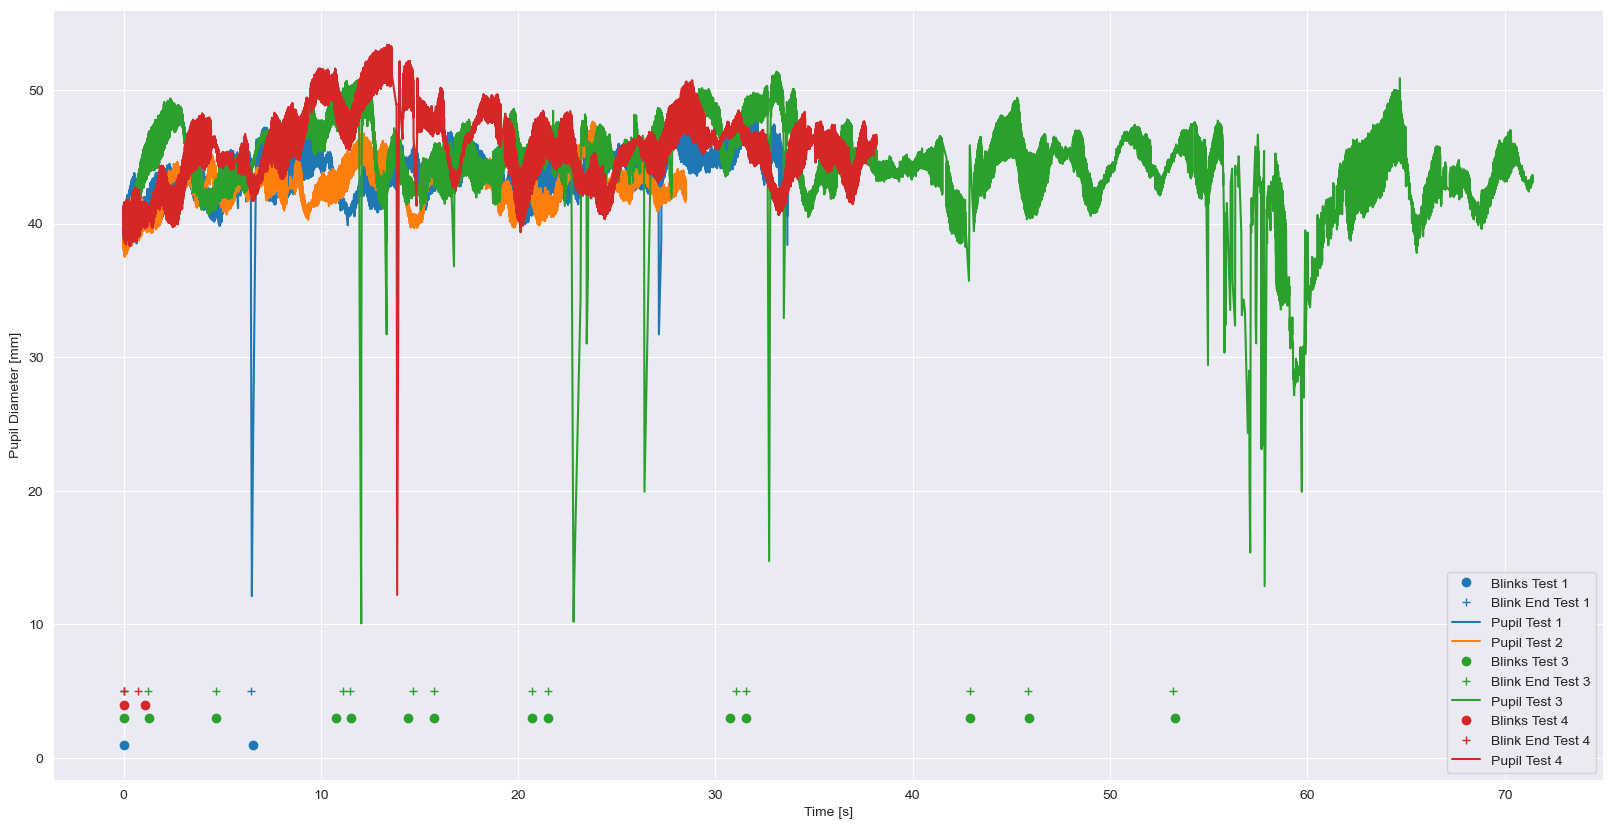

In [138]:
# plot the blink rate over time for all tests in one plot in different colors together with the pupil diameter. the color for all test 1 is red, for all test 2 is green, for all test 3 is blue, and for all test 4 is yellow. show the end of a blink with a cross
plt.figure(figsize=(20, 10))
for i in range(4):
    participant_test = participant_tests[0][i]
    participant_test_blinks = participant_test[2][0]
    participant_test_pupil = participant_test[4][0]
    if participant_test_blinks.shape[0] > 0:
        plt.plot(participant_test_blinks['start_timestamp'], np.ones(participant_test_blinks.shape[0])*(i+1), 'o', color='C' + str(i), label='Blinks Test ' + str(i+1))
        plt.plot(participant_test_blinks['end_timestamp'], np.ones(participant_test_blinks.shape[0])*5, '+', color='C'+str(i), label='Blink End Test ' + str(i+1))
        
    plt.plot(participant_test_pupil['pupil_timestamp'], participant_test_pupil['diameter'], label='Pupil Test ' + str(i+1))
plt.xlabel('Time [s]')
plt.ylabel('Pupil Diameter [mm]')
plt.legend()
plt.show()




## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [ ]:

# Load the data
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('your_dataset.csv')

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())



## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values


In [ ]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


In [ ]:
# Example: Plotting histograms of all numerical features
df.hist(figsize=(12, 12))
plt.show()


## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [ ]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


In [ ]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()
